In [ ]:
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def json_to_matrix(json_file):
  with open(json_file) as f:
    data = json.load(f)
  dates = []
  categories_id = []
  categories = []
  I = len(data)
  i = 0
  for element in data:
    date, time = element["date"].split("T")
    year, month, day = date.split("-")
    time = time.split(".")[0]
    hour, min, sec = time.split(":")
    date = datetime.datetime(int(year), int(month), int(day), int(hour), int(min))
    dates.append(date)
    for category in element["categories"]:
      if len(categories_id) == 0:
        categories_id.append(category["category"]["id"])
        categories.append(category["category"]["name"])
        M = np.zeros((I, 1))
        M[0, 0] = category["percentage"]
      else:
        if category["category"]["id"] in categories_id:
          j = categories_id.index(category["category"]["id"])
          M[i, j] = category["percentage"]
        else:
          categories_id.append(category["category"]["id"])
          categories.append(category["category"]["name"])
          j = len(categories_id)-1
          column = np.zeros((I, 1))
          M = np.concatenate([M, column], axis=1)
          M[i, j] = category["percentage"]
    i += 1
  return M, dates, categories_id, categories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/data.json'
M, dates, categories_id, categories = json_to_matrix(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.DataFrame(M, index=dates, columns=categories)
df.head()

,SECTOR Energía,Sector eléctrico,Consumo eléctrico,Impacto energético,Vulnerabilidad energética,Cambio climático,Calidad aire,Innovación,Movilidad sostenible,Gestión del agua,Redes eléctricas,Tarifas / mediciones eléctricas,Eficiencia energética,Smart Grids,GNL maritimo
2022-01-03,100.0,71.43,42.86,28.57,28.57,28.57,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
2022-01-04,100.0,0.00,0.00,91.67,0.00,33.33,33.33,25.00,25.00,25.00,0.0,0.0,0.0,0.0,0.0
2022-01-09,100.0,40.00,40.00,0.00,0.00,0.00,0.00,60.00,60.00,0.00,20.0,0.0,0.0,0.0,0.0
2022-01-10,100.0,0.00,0.00,100.00,0.00,35.29,17.65,0.00,0.00,47.06,0.0,0.0,0.0,0.0,0.0
2022-01-11,100.0,0.00,0.00,92.86,0.00,21.43,0.00,7.14,7.14,71.43,0.0,0.0,0.0,0.0,0.0


In [ ]:
i_split = dates.index(datetime.datetime(2022, 7, 1))

train_dates = dates[:i_split]
train = df.iloc[:i_split]

test_dates = dates[i_split:]
test = df.iloc[i_split:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# define generator
n_input = 5
n_features = len(categories_id)
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X, y = generator[0]
print(f'Given input X: \n{X}')
print(f'Predict this y: \n{y}')

Given input X: 
[[[1.     0.7143 0.4286 0.2857 1.     0.2857 0.     0.     0.     0.
   0.     0.     0.     0.     0.    ]
  [1.     0.     0.     0.9167 0.     0.3333 0.3333 0.25   0.25   0.25
   0.     0.     0.     0.     0.    ]
  [1.     0.4    0.4    0.     0.     0.     0.     0.6    0.6    0.
   0.2    0.     0.     0.     0.    ]
  [1.     0.     0.     1.     0.     0.3529 0.1765 0.     0.     0.4706
   0.     0.     0.     0.     0.    ]
  [1.     0.     0.     0.9286 0.     0.2143 0.     0.0714 0.0714 0.7143
   0.     0.     0.     0.     0.    ]]]
Predict this y: 
[[1.     0.5    0.3333 0.8333 0.     0.3333 0.     0.     0.     0.5
  0.     0.1667 0.     0.     0.    ]]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               46400     
                                                                 
 dense (Dense)               (None, 15)                1515      
                                                                 
Total params: 47,915
Trainable params: 47,915
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator, epochs=100)

Epoch 1/100
150/150 [==============================] - 3s 5ms/step - loss: 0.0392
Epoch 2/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0284
Epoch 3/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0276
Epoch 4/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0265
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0258
Epoch 6/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0253
Epoch 7/100
150/150 [==============================] - 1s 5ms/step - loss: 0.0250
Epoch 8/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0242
Epoch 9/100
150/150 [==============================] - 1s 7ms/step - loss: 0.0236
Epoch 10/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0229
Epoch 11/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0226
Epoch 12/100
150/150 [==============================] - 1s 6ms/step - loss: 0.0223
Epoch 13/100


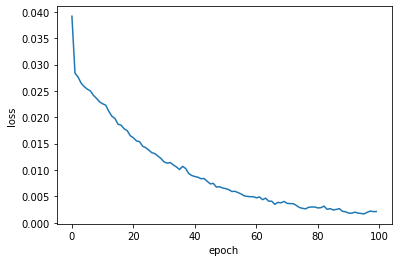

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
test_predictions = np.zeros((len(test), n_features))

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # add the prediction into the matrix
    test_predictions[i, :] = current_pred
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
def plot_category(category):
  test_data_ = test[category]
  i_cat = categories.index(category)
  test_predictions_ = scaler.inverse_transform(test_predictions)[:, i_cat]
  fig, ax = plt.subplots()
  fig.set_size_inches(10, 6)
  ax.plot(test_dates, test_data_)
  ax.plot(test_dates, test_predictions_)
  ax.set_title(f'Predictions for {category}', fontsize=16)
  ax.set_xlabel('date')
  ax.set_ylabel('percentage (%)')
  fig.autofmt_xdate()
  plt.grid()
  plt.legend(['test data', 'test predictions'])
  plt.show()
  rmse = sqrt(mean_squared_error(test_data_, test_predictions_))
  print(f'RMSE: {round(rmse, 2)}')

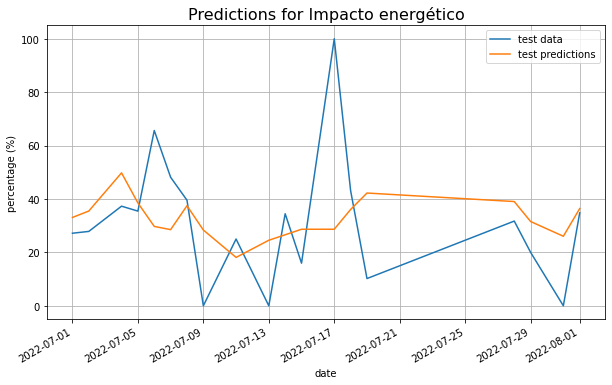

RMSE: 23.67


In [ ]:
plot_category('Impacto energético')

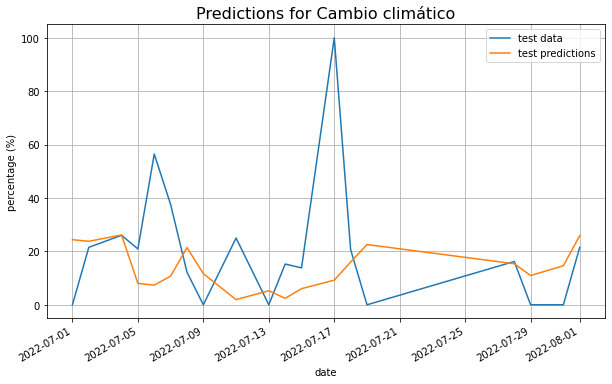

RMSE: 27.17


In [ ]:
plot_category('Cambio climático')

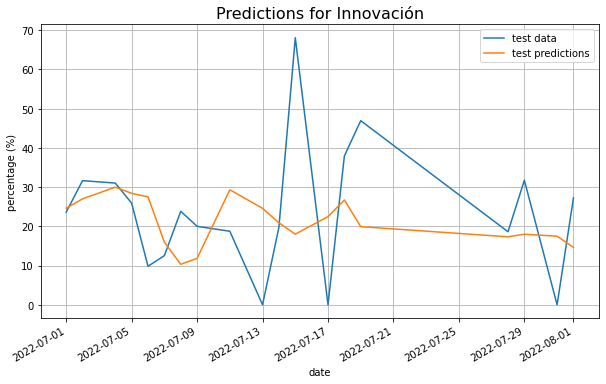

RMSE: 17.55


In [ ]:
plot_category('Innovación')

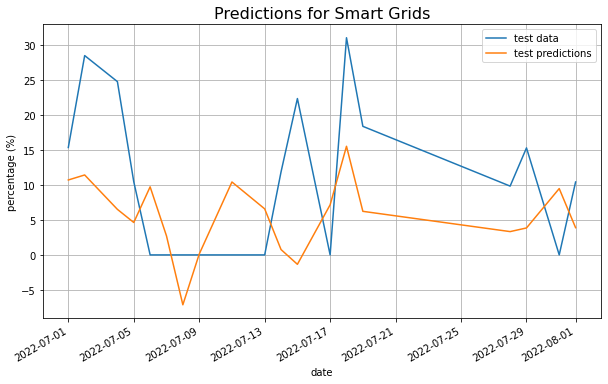

RMSE: 11.27


In [ ]:
plot_category('Smart Grids')

The LSTM model doesn't seem to have found a pattern in the data. The predictions have a similar accuracy to the predictions obtained with the linear regression, a much simpler model.

We have more or less daily data for 7 months, this doesn't seem a good dataset for predicting the behavior of the percentage of documents talking about a certain category. It would make more sense to predict the percentages of the categories from a dataset with monthly data for 10 years.

One weakness of this model is that it assumes that time steps are constant, which are not. Data hasn't been collected on a regular daily baisis. Anyway, I don't think that's the reason of the poor predictions.

According to the research I've done, LSTM seems to be a good option for finding complex patterns in time series data and make predictions. It would be interesting to apply LSTM for predicting other time dependent data, for example the NSI.